In [1]:
suppressMessages(library(fable))
suppressMessages(library(forecast))
suppressMessages(library(tidyverse))
suppressMessages(library(tsibble))
suppressMessages(library(scales))
suppressMessages(library(feasts))
suppressMessages(library(magrittr))
suppressMessages(library(tsibble))
suppressMessages(library(dplyr))
suppressMessages(library(ggplot2))
suppressMessages(library(lubridate))
suppressMessages(library(gridExtra))
suppressMessages(library(tidyr))

In [2]:
data <- read.csv('monthly_housing_inventory.csv')

In [3]:
df <- read.csv('monthly_housing_inventory.csv')
National <- df %>%
mutate(feet = median_square_feet * total_listing_count) %>%
group_by(month_date_yyyymm) %>%
summarise(
    total_listings = sum(total_listing_count, na.rm = TRUE),
    price = sum(median_listing_price,na.rm = TRUE),
    feet = sum(feet, na.rm=TRUE),
    total_active_listings = sum(active_listing_count,na.rm = TRUE), .groups='drop',
) %>%
mutate(wgt_median_square_feet = feet / total_listings, wgt_median_price = price / total_listings) %>%
mutate(month_date = tsibble::yearmonth(as.character(month_date_yyyymm), '%Y%m')) %>%

as_tsibble(index=month_date)

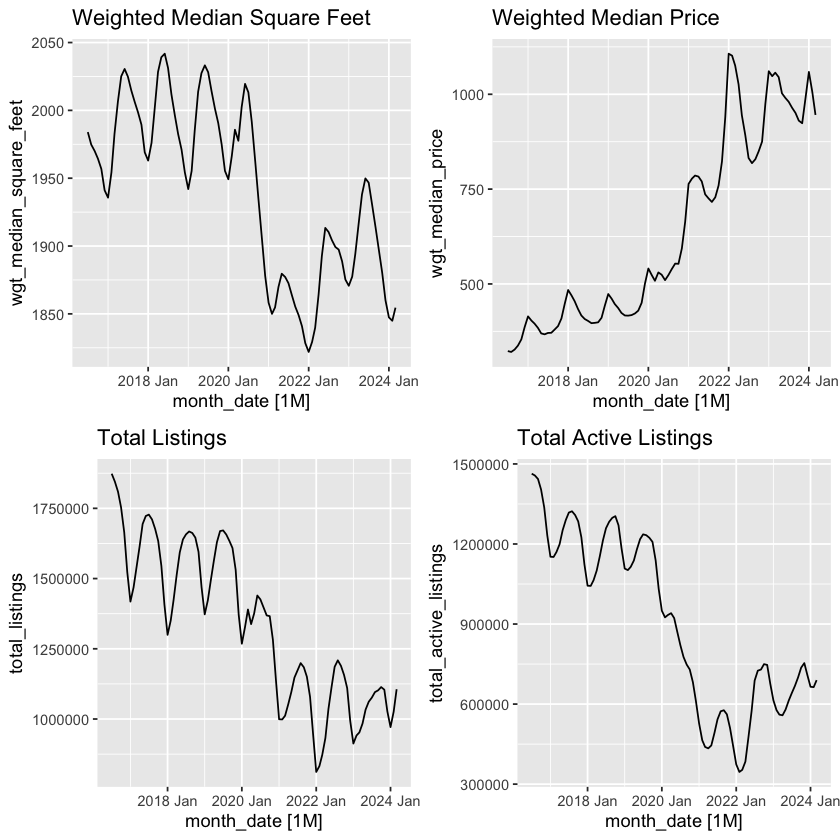

In [4]:
library(ggplot2)
library(gridExtra)
library(magrittr)

# Create separate plots for each series
plot1 <- National %>%
  autoplot(wgt_median_square_feet) +
  labs(title = "Weighted Median Square Feet")

plot2 <- National %>%
  autoplot(wgt_median_price) +
  labs(title = "Weighted Median Price")

plot3 <- National %>%
  autoplot(total_listings) +
  labs(title = "Total Listings")

plot4 <- National %>%
  autoplot(total_active_listings) +
  labs(title = "Total Active Listings")

# Arrange plots in a grid
grid.arrange(plot1, plot2, plot3, plot4, ncol = 2)

# Median Listing Price

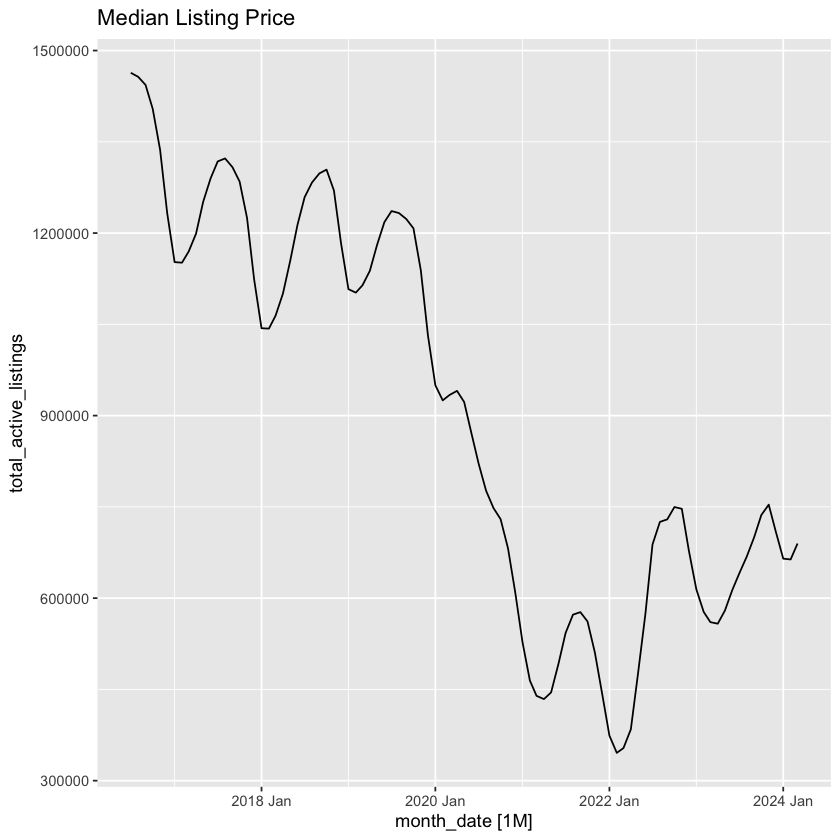

In [5]:
National |> autoplot(total_active_listings) +
  labs(title = "Median Listing Price")

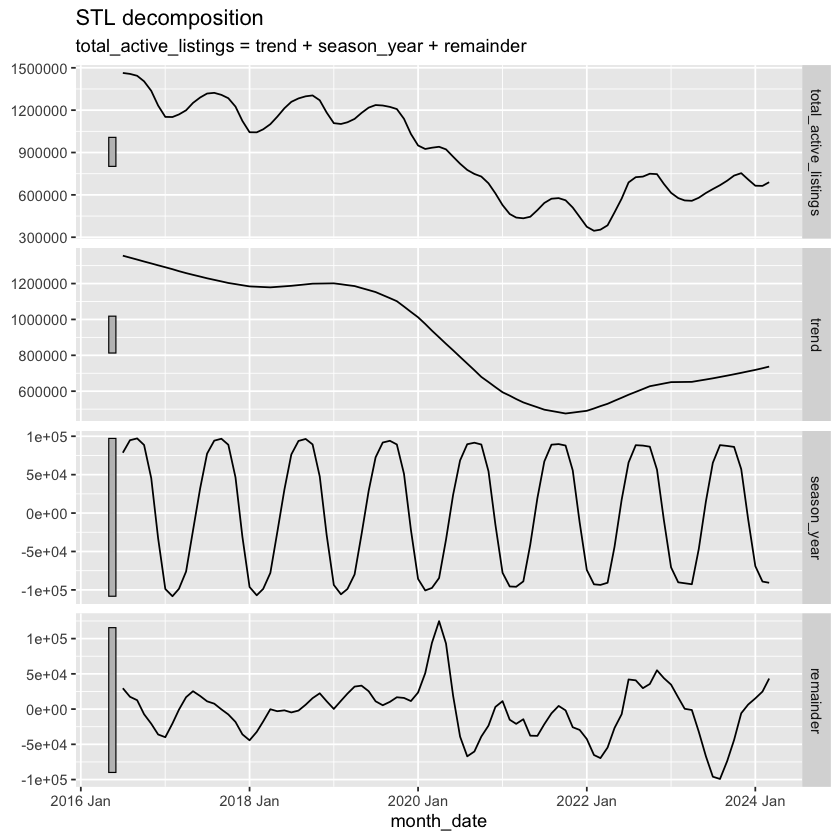

In [6]:
components <- National |> fill_gaps() |> model(
    stl = STL(total_active_listings ~ season(), robust = TRUE)
  ) |>
  components()
components |> autoplot()

# Outliers

In [7]:
outliers <- components |>filter(
    remainder < quantile(remainder, 0.25) - 3*IQR(remainder) |
    remainder > quantile(remainder, 0.75) + 3*IQR(remainder)
  )
outliers |> select(total_active_listings)

total_active_listings,month_date,.model
<dbl>,<mth>,<chr>


# No outliers :)

In [8]:
missing <- National |> select(total_active_listings) |>
  # Replace with missing values
  fill_gaps()

In [9]:
total_active_listings <- National |> select(total_active_listings)
total_active_listings <- missing |>
  # Fit ARIMA model to the data containing missing values
  model(ARIMA(total_active_listings)) |>
  # Estimate Trips for all periods
  interpolate(missing)

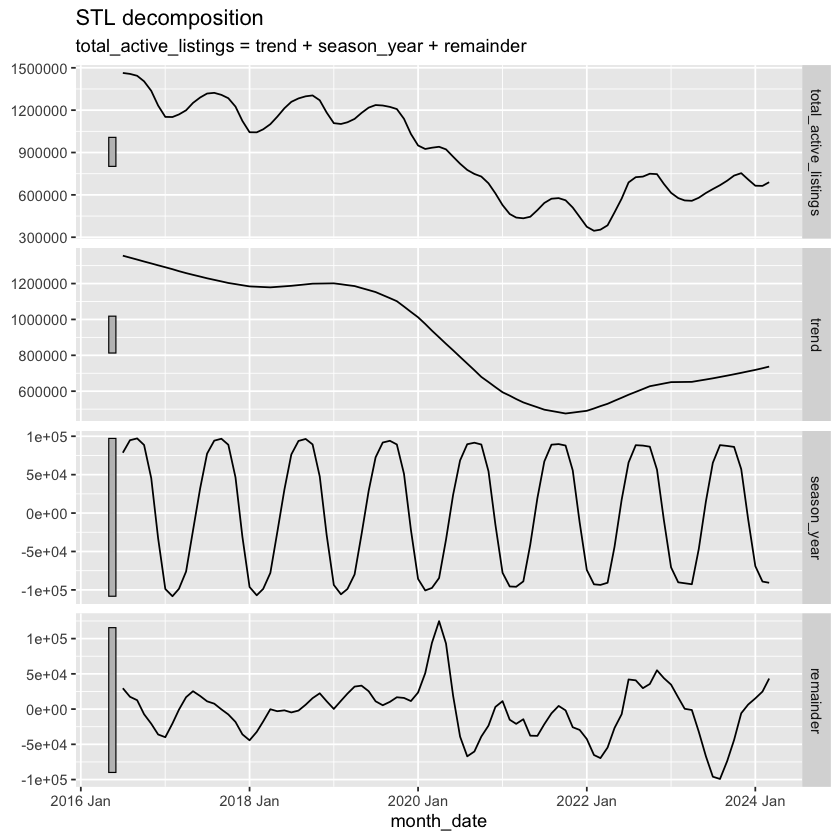

In [10]:
components <- total_active_listings |> model(
    stl = STL(total_active_listings ~ season(), robust = TRUE)
  ) |>
  components()
components |> autoplot()

In [11]:
ts <- ts(total_active_listings$total_active_listings,start=c(2016,6), frequency = 12)

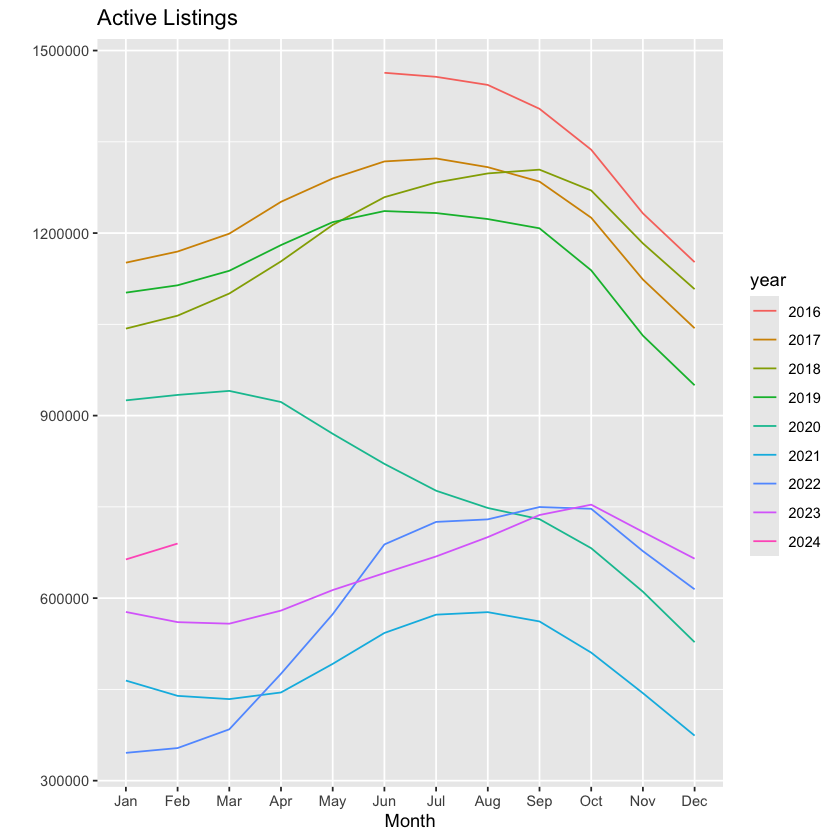

In [12]:
ts |> ggseasonplot() + labs(title = "Active Listings")

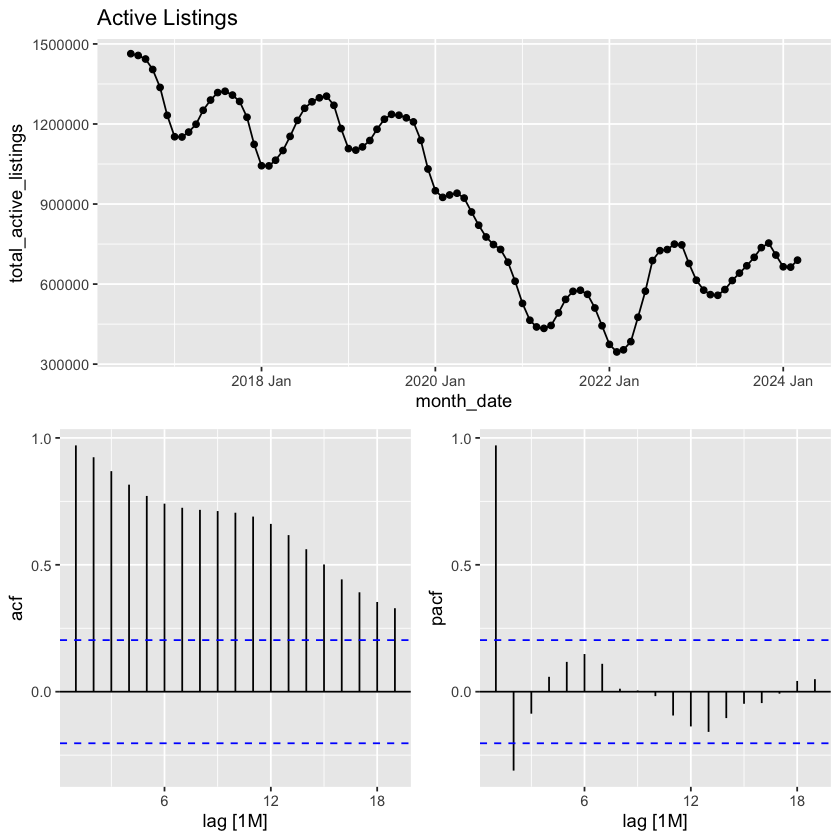

In [13]:
total_active_listings |> gg_tsdisplay(total_active_listings, plot_type = 'partial') + labs(title='Active Listings')

# Description of the data

<br>Seaonal data with constant seasonality

Decreasing trend




# Modeling and Training

# Test Train Split

In [14]:
training <- total_active_listings %>% filter_index(. ~ '2022 Mar')
test <- total_active_listings %>% filter_index('2022 Apr' ~ .)

In [15]:
# models to use  snaive,random walk, ets, arima

In [16]:
models <- training |>
model(
    'ETS' = ETS(total_active_listings),
    'ARIMA' = ARIMA(total_active_listings),
    'SNAIVE' = SNAIVE(total_active_listings),
    'RW' = RW(total_active_listings ~ drift())
)

In [17]:
models %>% report()

Warning message in report.mdl_df(.):
“Model reporting is only supported for individual models, so a glance will be shown. To see the report for a specific model, use `select()` and `filter()` to identify a single model.”


.model,sigma2,log_lik,AIC,AICc,BIC,MSE,AMSE,MAE,ar_roots,ma_roots
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<list>,<list>
ETS,606007483,-833.9908,1703.982,1717.662,1744.196,456701292,1798224918,15698.14,NULL,NULL
ARIMA,218118709,-617.8642,1243.728,1244.513,1251.830,NA,NA,NA,1.512258+0i,"0.5319883+0.9214307i, -0.9214307+0.5319883i, -0.5319883-0.9214307i, 0.9214307-0.5319883i, 0.0000000+1.0639765i, -1.0639765-0.0000000i, 0.0000000-1.0639765i, 1.0639765+0.0000000i, -0.5319883+0.9214307i, -0.9214307-0.5319883i, 0.5319883-0.9214307i, 0.9214307+0.5319883i, -1.6274835+0.0000000i"
SNAIVE,28493641831,NA,NA,NA,NA,NA,NA,NA,NULL,NULL
RW,1984007676,NA,NA,NA,NA,NA,NA,NA,NULL,NULL


In [18]:
models |> accuracy() |> select(.model,RMSE, ACF1, MAPE)

.model,RMSE,ACF1,MAPE
<chr>,<dbl>,<dbl>,<dbl>
ETS,21370.57,0.60050102,1.962593
ARIMA,12943.74,0.04302159,1.198224
SNAIVE,241139.17,0.97767859,28.571646
RW,44213.47,0.77987864,4.334702


# Residual Analysis

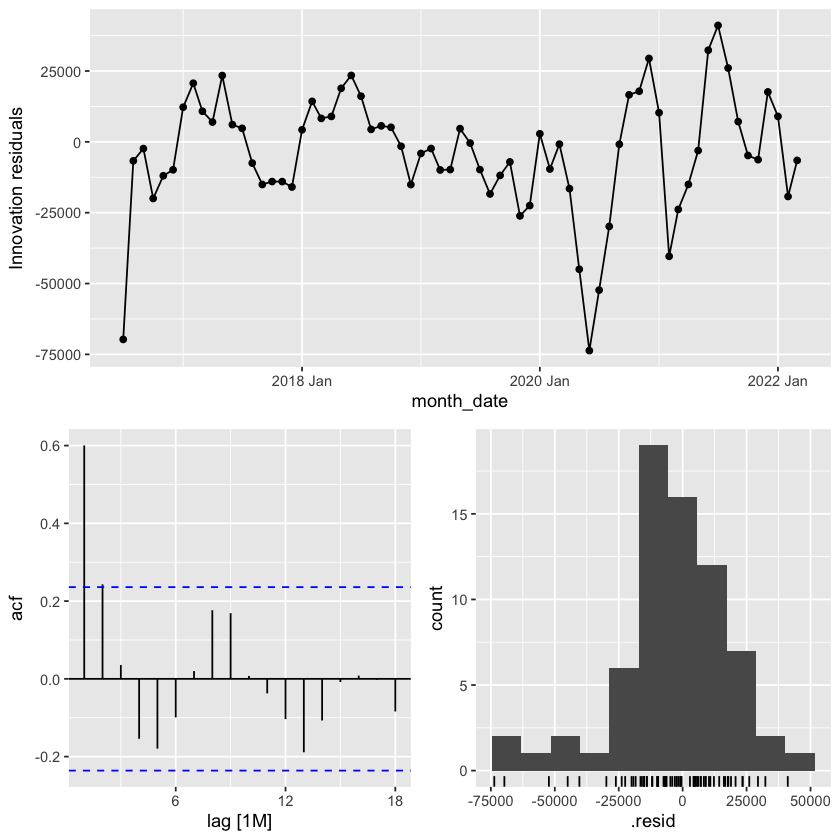

In [19]:
models %>% select(ETS) %>% gg_tsresiduals()

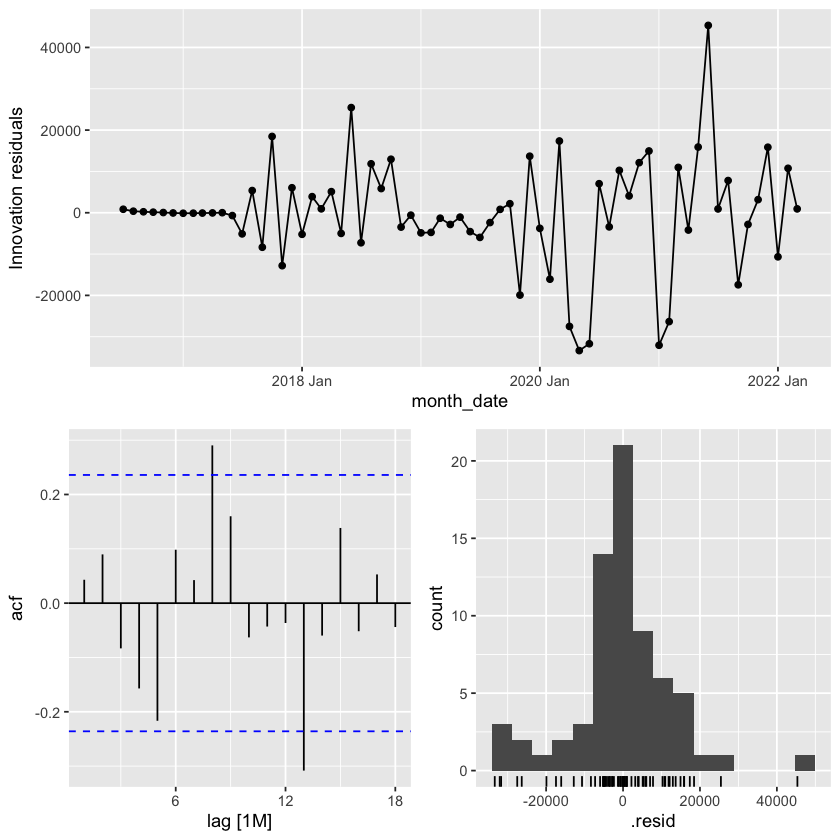

In [20]:
models %>% select(ARIMA) %>% gg_tsresiduals()

Warning message:
“Removed 12 rows containing missing values or values outside the scale range
(`geom_line()`).”
Warning message:
“Removed 12 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 12 rows containing non-finite outside the scale range (`stat_bin()`).”


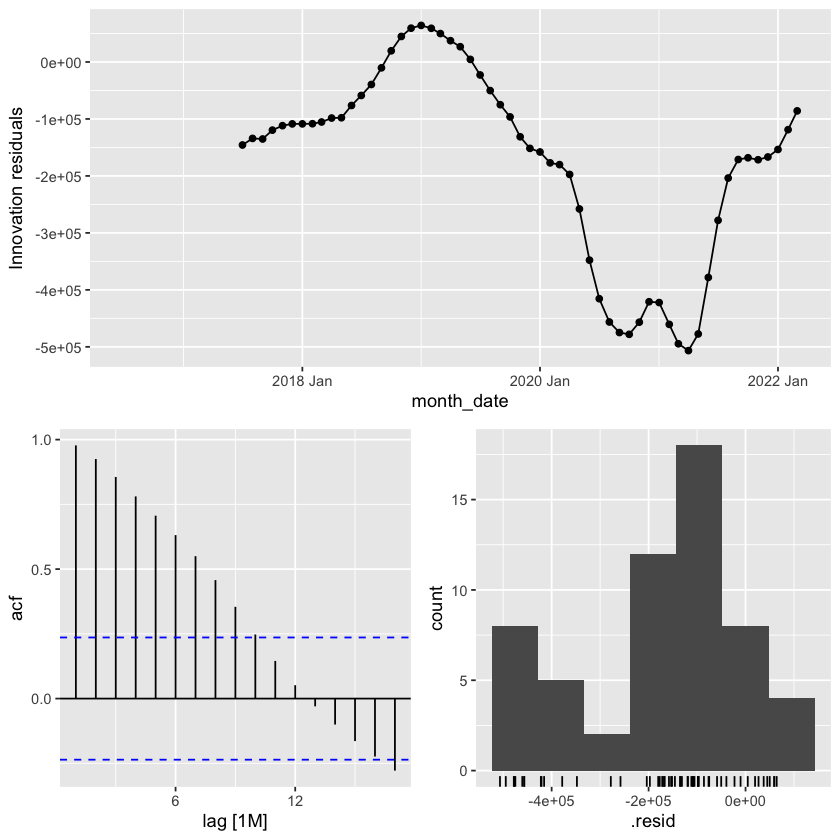

In [21]:
models %>% select(SNAIVE) %>% gg_tsresiduals()

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_line()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 1 row containing non-finite outside the scale range (`stat_bin()`).”


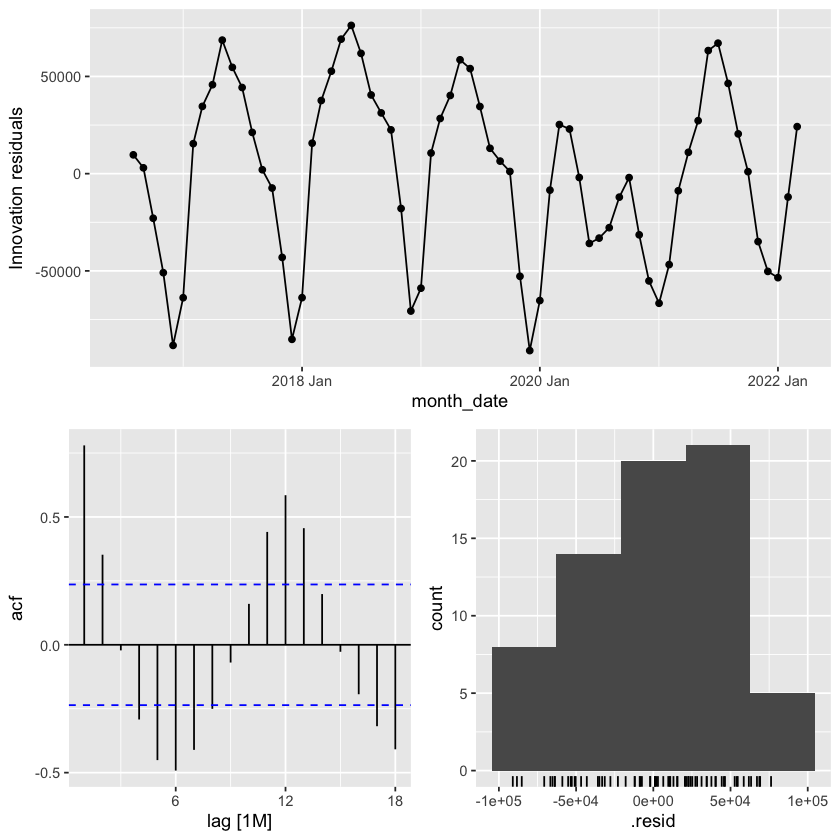

In [22]:
models %>% select(RW) %>% gg_tsresiduals()

# BEST Model is ARIMA on Training set after checking the RMSE and Residuals

# Test Performance

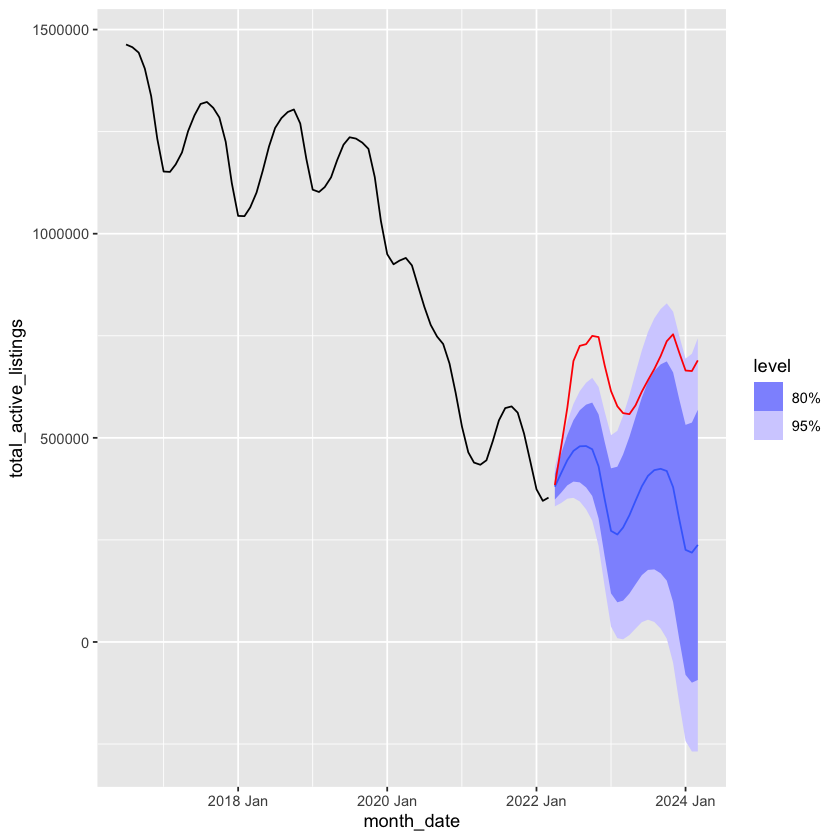

In [23]:
forecast_ETS <- models %>% select(ETS) %>% forecast(test)

forecast_ETS %>% autoplot(training) +
autolayer(test, total_active_listings, col='red')

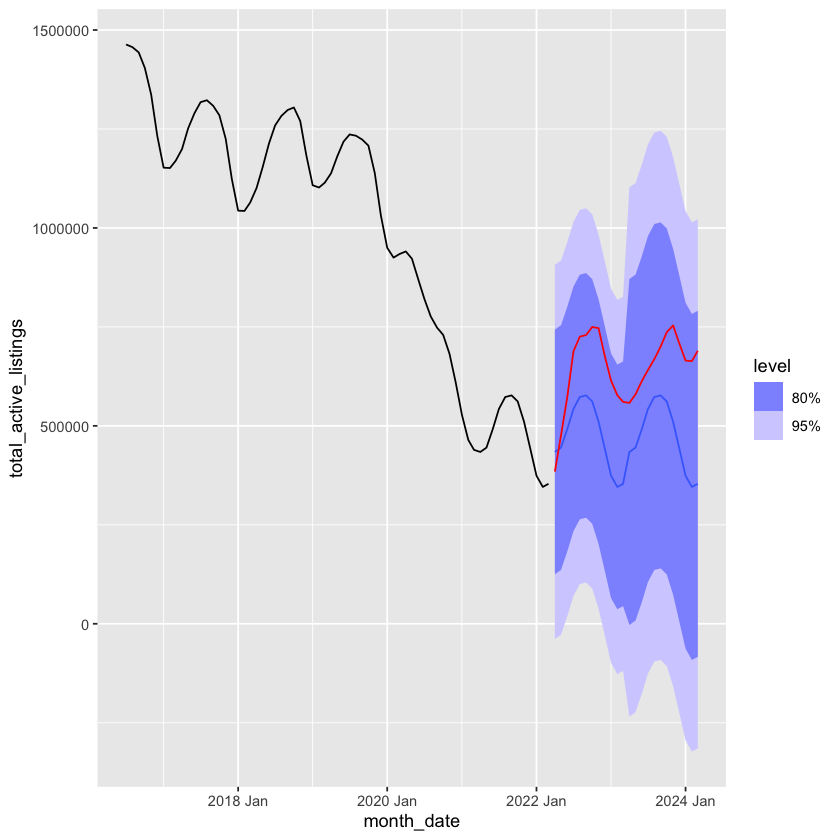

In [24]:
forecast_SNAIVE <- models %>% select(SNAIVE) %>% forecast(test)

forecast_SNAIVE  %>% autoplot(training) +
autolayer(test, total_active_listings, col='red')

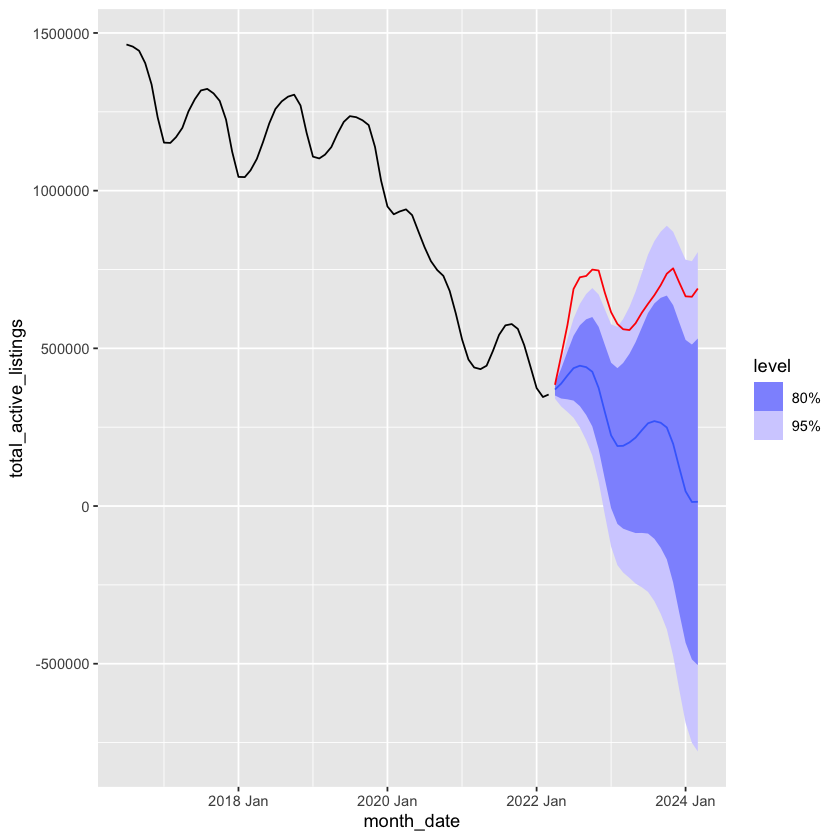

In [25]:
forecast_ARIMA <- models %>% select(ARIMA) %>% forecast(test)

forecast_ARIMA  %>% autoplot(training) +
autolayer(test, total_active_listings, col='red')

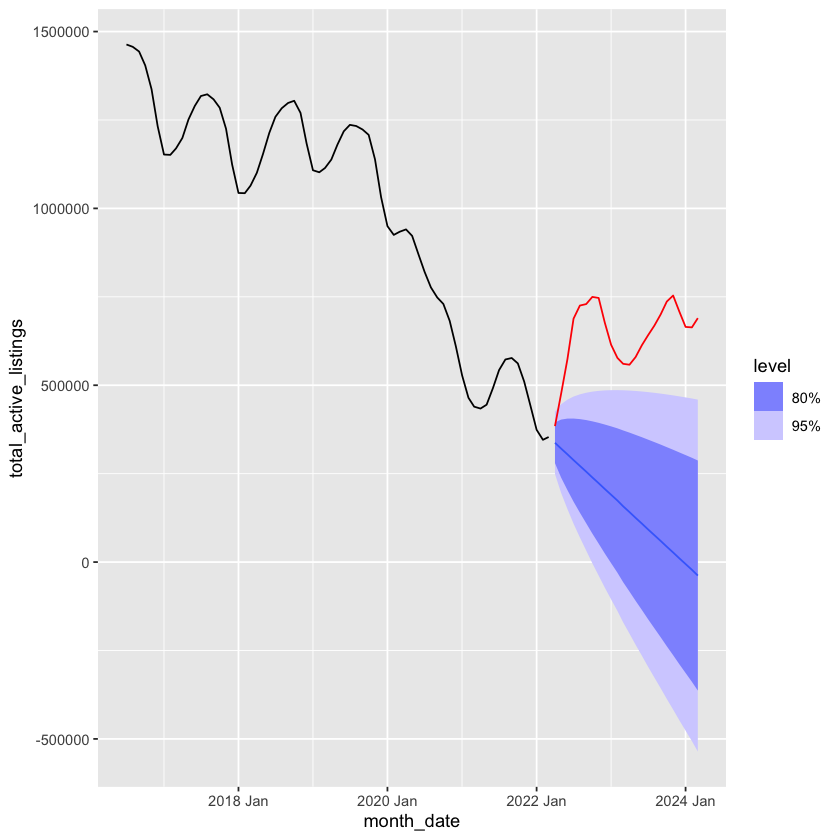

In [26]:
forecast_RW <- models %>% select(RW) %>% forecast(test)

forecast_RW  %>% autoplot(training) +
autolayer(test, total_active_listings, col='red')

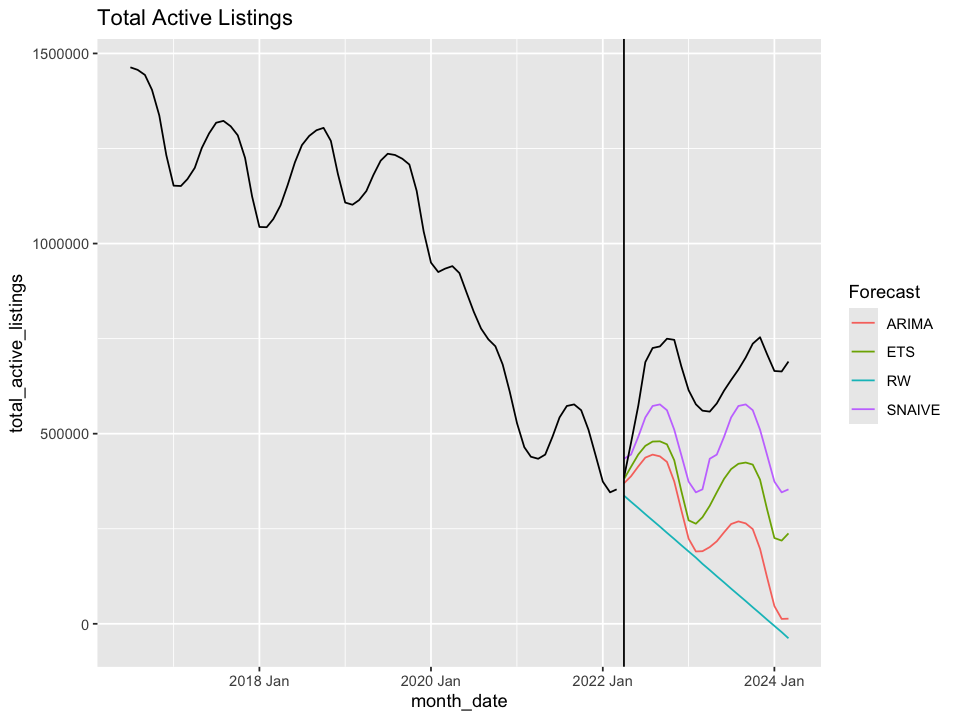

In [27]:
options(repr.plot.width=8, repr.plot.height=6)
fit <- models |> forecast(h = 24)

# Plot forecasts against actual values
fit |>
  autoplot(training, level = NULL) +
  geom_vline(xintercept = as.Date('2022-04-01'))+
  autolayer(test, total_active_listings,
    colour = "black"
  ) +
  labs(
    y = "total_active_listings",
    title = "Total Active Listings"
  ) +
  guides(colour = guide_legend(title = "Forecast"))

In [28]:
fabletools::accuracy(forecast_ETS, total_active_listings) |> select(.model,RMSE, ACF1, MAPE)
fabletools::accuracy(forecast_ARIMA, total_active_listings) |> select(.model,RMSE, ACF1, MAPE)
fabletools::accuracy(forecast_SNAIVE, total_active_listings) |> select(.model,RMSE, ACF1, MAPE)
fabletools::accuracy(forecast_RW, total_active_listings) |> select(.model,RMSE, ACF1, MAPE)

.model,RMSE,ACF1,MAPE
<chr>,<dbl>,<dbl>,<dbl>
ETS,298335.5,0.7549012,42.05517


.model,RMSE,ACF1,MAPE
<chr>,<dbl>,<dbl>,<dbl>
ARIMA,414798.1,0.7892377,57.9405


.model,RMSE,ACF1,MAPE
<chr>,<dbl>,<dbl>,<dbl>
SNAIVE,195644.3,0.7090571,27.09732


.model,RMSE,ACF1,MAPE
<chr>,<dbl>,<dbl>,<dbl>
RW,524058.9,0.7676453,74.80608


.model	RMSE	ACF1	MAPE
<chr>	<dbl>	<dbl>	<dbl>
    
ETS	298335.5	0.7549012	42.05517

ARIMA	414798.1	0.7892377	57.9405

SNAIVE	195644.3	0.7090571	27.09732

RW	524058.9	0.7676453	74.80608


# Best performer on the Test set is SNAIVE

Plot variable not specified, automatically selected `.vars = total_active_listings`


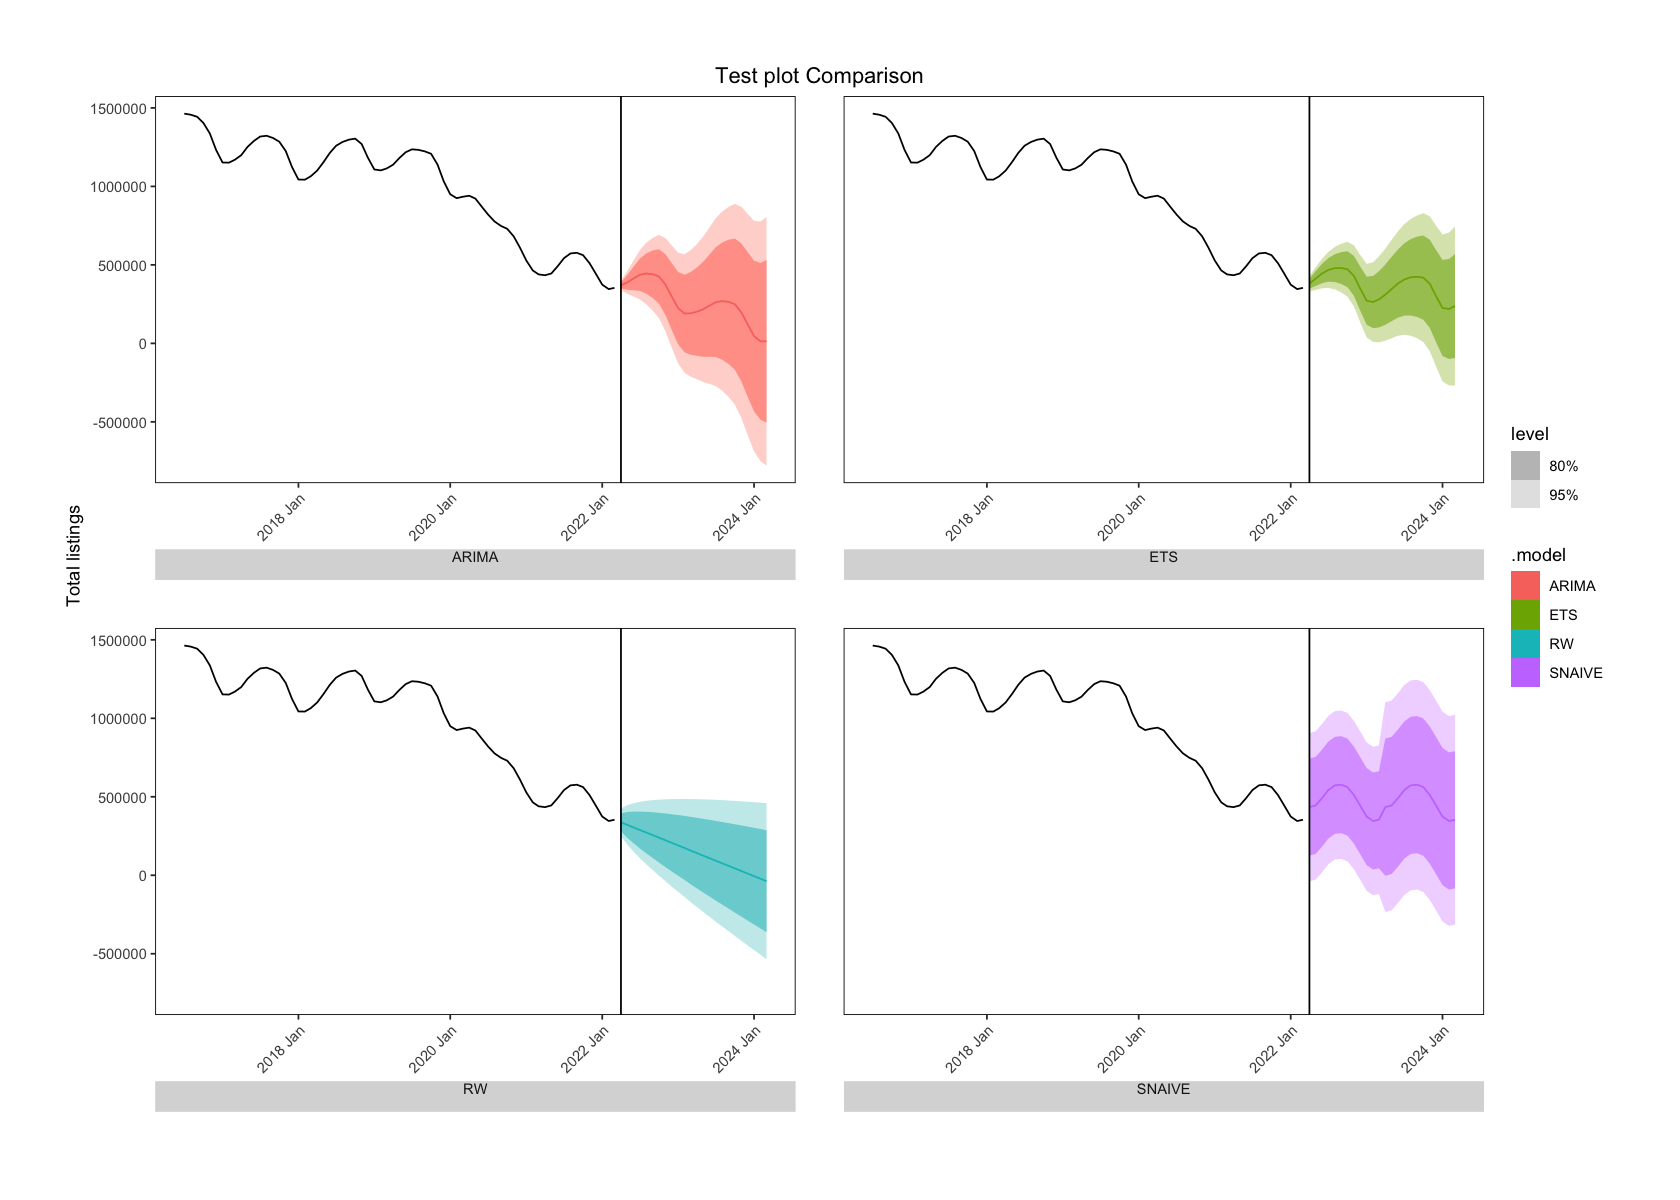

In [29]:
options(repr.plot.width=14, repr.plot.height=10)
models |> forecast(test) |> autoplot() +
facet_wrap(. ~ .model,strip.position = "bottom", scales = "free_x") +
autolayer(training) +
labs(title='Test plot Comparison', y='Total listings', x='') +
geom_vline(xintercept = as.Date('2022-04-01'))+
theme(strip.text.x = element_text(margin = margin(b = 10)),
        strip.placement = "outside")+theme(panel.spacing = unit(2, "lines")) +
theme(plot.title = element_text(hjust = 0.5)) +  # Center the plot title
  theme(plot.margin = margin(40, 40, 40, 40)) +  # Adjust the plot margins
  theme(plot.background = element_rect(fill = "white")) +  # Set plot background color to white
  theme(panel.background = element_rect(fill = "white")) +  # Set panel background color to white
  theme(panel.border = element_rect(color = "black", fill = NA)) +  # Set panel border color to black
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) 

# Forecasts

In [30]:
forecasts <- total_active_listings |> 
model(
    'ETS' = ETS(total_active_listings),
    'ARIMA' = ARIMA(total_active_listings),
    'SNAIVE' = SNAIVE(total_active_listings),
    'RW' = RW(total_active_listings ~ drift())
) |> forecast(h=12)

Plot variable not specified, automatically selected `.vars = total_active_listings`


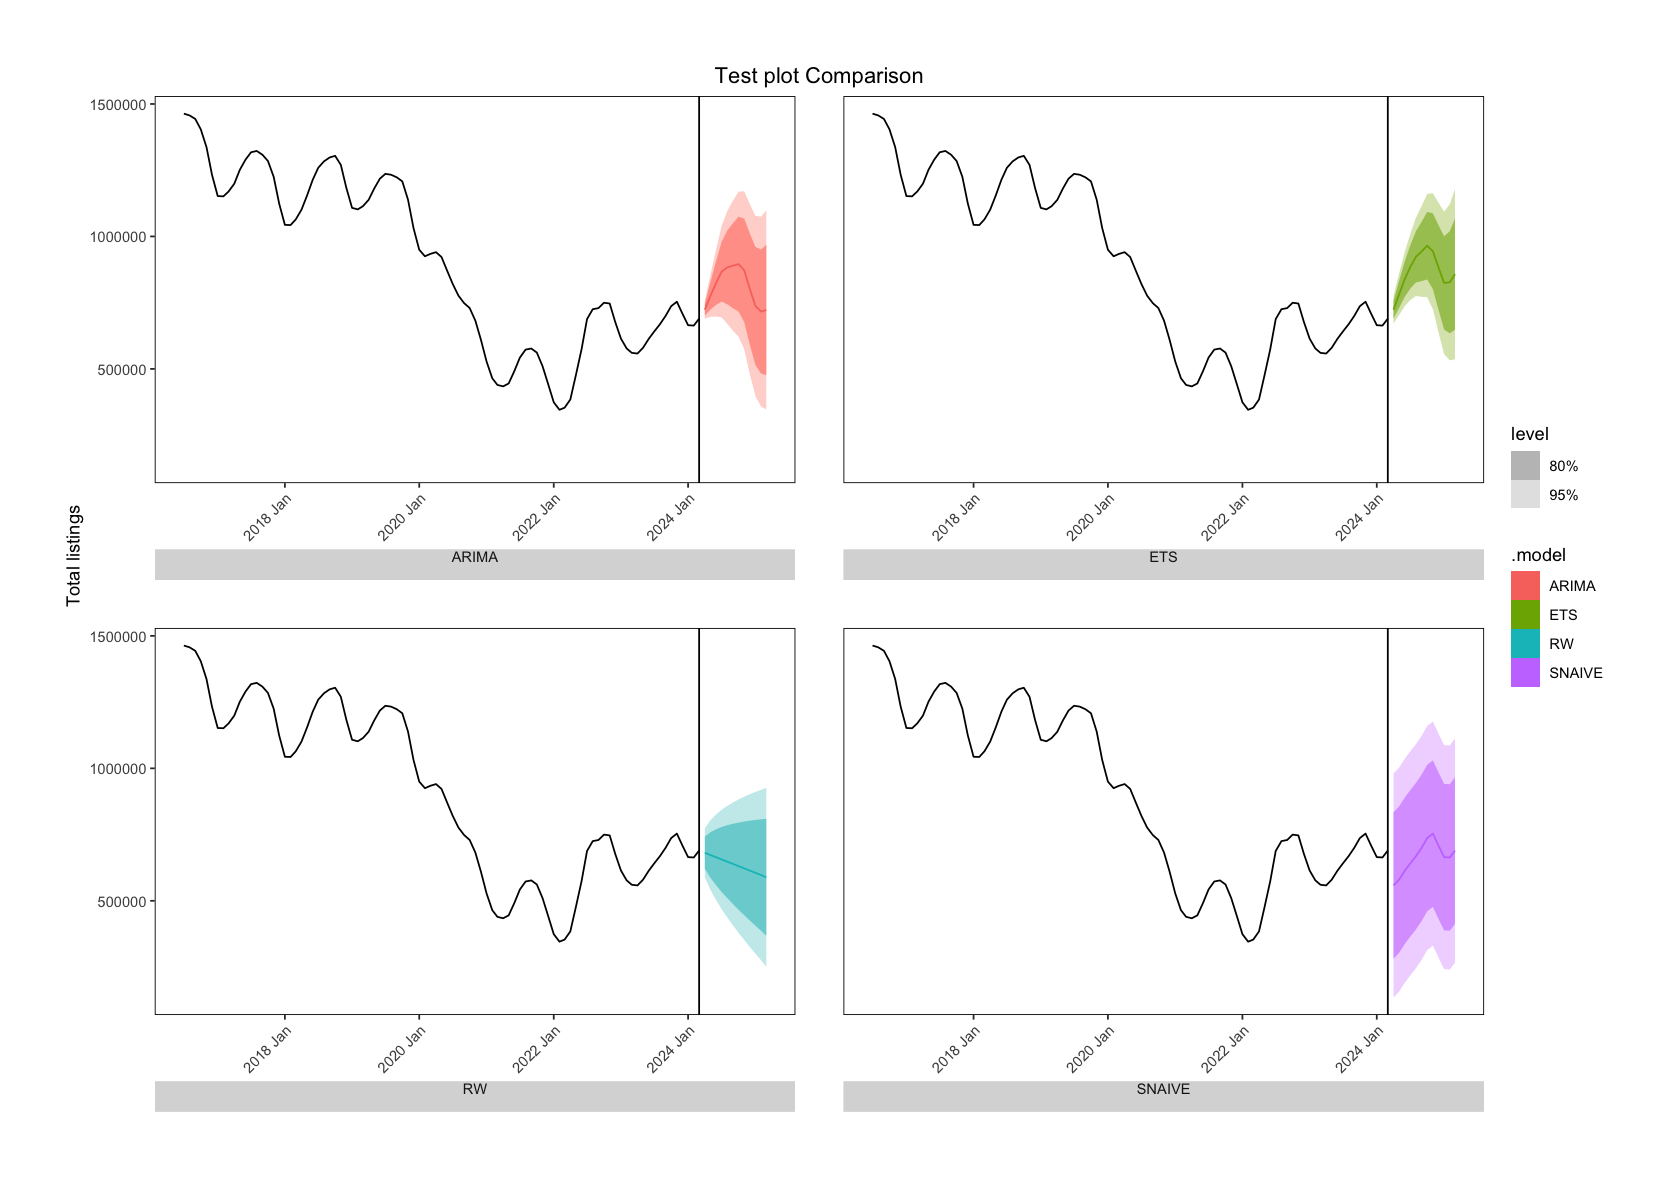

In [31]:
forecasts |> autoplot() +
facet_wrap(. ~ .model,strip.position = "bottom", scales = "free_x") +
autolayer(total_active_listings) +
labs(title='Test plot Comparison', y='Total listings', x='') +
geom_vline(xintercept = as.Date('2024-03-01'))+
theme(strip.text.x = element_text(margin = margin(b = 10)),
        strip.placement = "outside")+theme(panel.spacing = unit(2, "lines")) +
theme(plot.title = element_text(hjust = 0.5)) +  # Center the plot title
  theme(plot.margin = margin(40, 40, 40, 40)) +  # Adjust the plot margins
  theme(plot.background = element_rect(fill = "white")) +  # Set plot background color to white
  theme(panel.background = element_rect(fill = "white")) +  # Set panel background color to white
  theme(panel.border = element_rect(color = "black", fill = NA)) +  # Set panel border color to black
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) 

In [34]:
forecasts |> filter(.model == "SNAIVE")

.model,month_date,total_active_listings,.mean
<chr>,<mth>,<dist>,<dbl>
SNAIVE,2024 Apr,"N(558008, 4.7e+10)",558008
SNAIVE,2024 May,"N(579555, 4.7e+10)",579555
SNAIVE,2024 Jun,"N(613284, 4.7e+10)",613284
SNAIVE,2024 Jul,"N(641204, 4.7e+10)",641204
SNAIVE,2024 Aug,"N(668512, 4.7e+10)",668512
SNAIVE,2024 Sep,"N(7e+05, 4.7e+10)",700298
SNAIVE,2024 Oct,"N(736621, 4.7e+10)",736621
SNAIVE,2024 Nov,"N(753624, 4.7e+10)",753624
SNAIVE,2024 Dec,"N(708888, 4.7e+10)",708888


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 558008  634224  666690  664848  702446  753624 


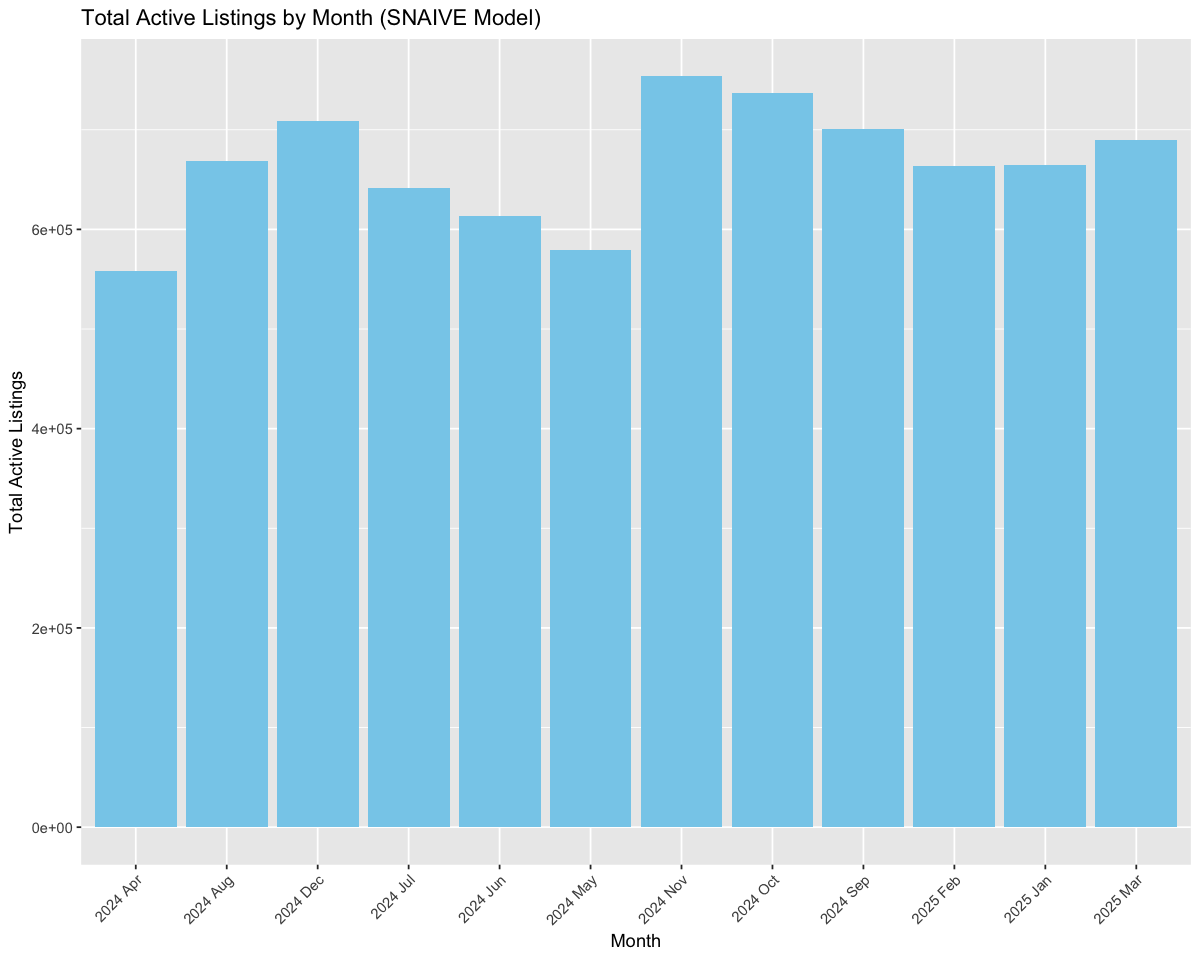

In [37]:
library(ggplot2)
options(repr.plot.width=10, repr.plot.height=8)

ets_forecasts <- data.frame(
  .model = c("SNAIVE", "SNAIVE", "SNAIVE", "SNAIVE", "SNAIVE", "SNAIVE",
             "SNAIVE", "SNAIVE", "SNAIVE", "SNAIVE", "SNAIVE", "SNAIVE"),
  month_date = c("2024 Apr", "2024 May", "2024 Jun", "2024 Jul", 
                 "2024 Aug", "2024 Sep", "2024 Oct", "2024 Nov", 
                 "2024 Dec", "2025 Jan", "2025 Feb", "2025 Mar"),
  total_active_listings = c(558008, 579555, 613284, 641204,
                            668512, 700298, 736621, 753624,
                            708888, 664869, 663586, 689728)
)

# Calculating summary statistics
summary_stats <- summary(ets_forecasts$total_active_listings)

# bar plot of Total Active Listings
bar_plot <- ggplot(ets_forecasts, aes(x = month_date, y = total_active_listings)) +
  geom_bar(stat = "identity", fill = "skyblue") +
  labs(title = "Total Active Listings by Month (SNAIVE Model)",
       x = "Month",
       y = "Total Active Listings") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))


print(summary_stats)
print(bar_plot)
